In [1]:
!pip install opencv-python

DEPRECATION: Loading egg at c:\python 37\lib\site-packages\chatbotai-0.3.1.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Pre-processing : Detect faces and eyes

In [3]:
img = cv2.imread("./test_images/ryan-test.jpg")
img.shape

(295, 236, 3)

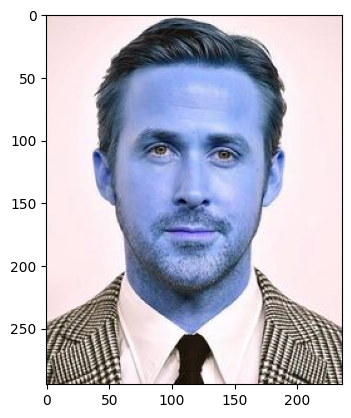

In [4]:
plt.imshow(img)

In [5]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray.shape

(295, 236)

In [6]:
gray

array([[221, 220, 219, ..., 222, 222, 223],
       [222, 220, 219, ..., 223, 223, 223],
       [222, 221, 220, ..., 224, 225, 225],
       ...,
       [ 48,  33,  15, ..., 189, 190, 164],
       [123, 104,  33, ..., 147, 182, 120],
       [135,  80,  20, ..., 133, 251, 243]], dtype=uint8)

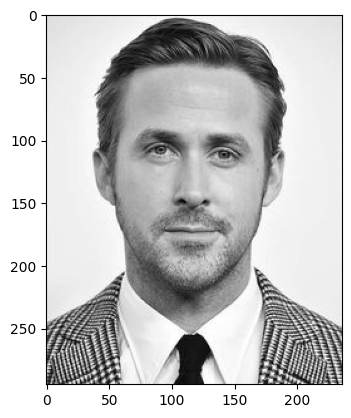

In [7]:
plt.imshow(gray,cmap='gray')

In [8]:
face_cascade = cv2.CascadeClassifier('.\opencv\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('.\opencv\haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 34,  43, 169, 169]])

In [9]:
(x,y,w,h) = faces[0]
x,y,w,h

(34, 43, 169, 169)

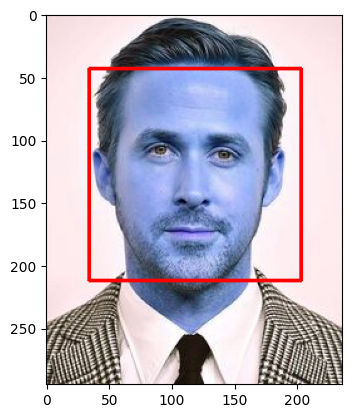

In [10]:
face_img = cv2.rectangle(img, (x,y),(x+w, y+h), (255,0,0),2)
plt.imshow(face_img)

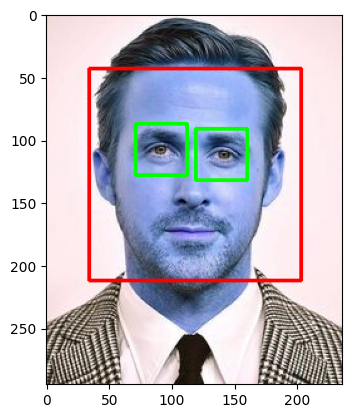

In [11]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

Crop the facial region

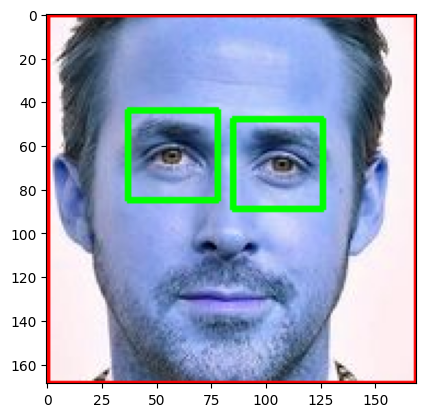

In [12]:
# roi = region of interest ----> it is croping the face
%matplotlib inline
plt.imshow(roi_color,cmap='gray')

In [13]:
cropped_img = np.array(roi_color)
cropped_img.shape

(169, 169, 3)

Use Wavelet Transform as a feature for training our model

In [14]:
!pip install PyWavelets

DEPRECATION: Loading egg at c:\python 37\lib\site-packages\chatbotai-0.3.1.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

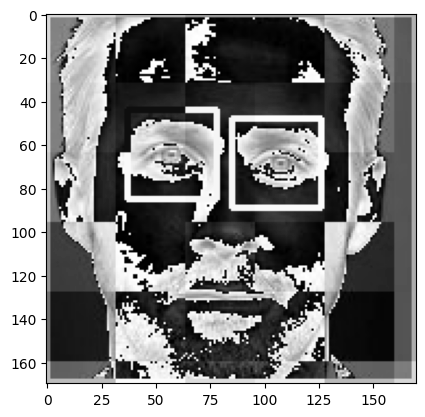

In [16]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

Load image, detect face. If eyes >=2, then save and crop the face region

In [17]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

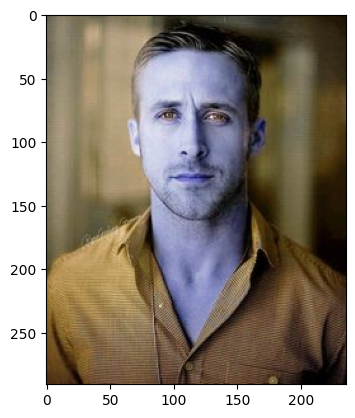

In [18]:
original_image = cv2.imread('./test_images/ryan-test2.jpg')
plt.imshow(original_image)

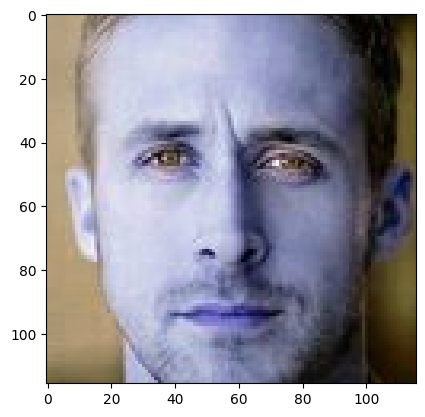

In [19]:

cropped_image = get_cropped_image_if_2_eyes('./test_images/ryan-test2.jpg')
plt.imshow(cropped_image)

In [20]:
path_to_data = "./dataset/"
path_to_crop_data = "./dataset/cropped/"

In [21]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
          if entry.is_dir():
                  img_dirs.append(entry.path)

In [22]:
img_dirs

['./dataset/BenedictCumberbatch',
 './dataset/CilianMurphy',
 './dataset/DakotaJhonson',
 './dataset/EmmaStone',
 './dataset/RyanGosling']

Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code

In [23]:
import shutil
if os.path.exists(path_to_crop_data):
          shutil.rmtree(path_to_crop_data)
os.mkdir(path_to_crop_data)

In [24]:
cropped_image_dirs = []
celebrity_files_name_dict = {}

for img_dir in img_dirs:
          count = 1
          celebrity_name = img_dir.split('/')[-1]
          print(celebrity_name)

          celebrity_files_name_dict[celebrity_name] = []

          for entry in os.scandir(img_dir):
                  roi_color = get_cropped_image_if_2_eyes(entry.path)
                  if roi_color is not None:
                          cropped_folder = path_to_crop_data + celebrity_name
                          if not os.path.exists(cropped_folder):
                                  os.makedirs(cropped_folder)
                                  cropped_image_dirs.append(cropped_folder)
                                  print("Generating cropped images in folder : ",cropped_folder)

                          cropped_file_name = celebrity_name + str(count) + ".png"
                          cropped_file_path = cropped_folder + "/" + cropped_file_name

                          cv2.imwrite(cropped_file_path, roi_color)
                          celebrity_files_name_dict[celebrity_name].append(cropped_file_path)
                          count += 1


BenedictCumberbatch
Generating cropped images in folder :  ./dataset/cropped/BenedictCumberbatch
CilianMurphy
Generating cropped images in folder :  ./dataset/cropped/CilianMurphy
DakotaJhonson
Generating cropped images in folder :  ./dataset/cropped/DakotaJhonson
EmmaStone
Generating cropped images in folder :  ./dataset/cropped/EmmaStone
RyanGosling
Generating cropped images in folder :  ./dataset/cropped/RyanGosling


Now you should have cropped folder under datasets folder that contains cropped images

Manually examine cropped folder and delete any unwanted images

In [25]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'BenedictCumberbatch': ['./dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch1.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch10.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch11.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch12.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch13.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch14.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch15.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch16.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch17.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch18.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch19.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch2.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch20.png',
  './dataset/cropped/BenedictCumberbatch\\BenedictCumberbatch21.png',

In [26]:
class_dict = {}
count = 0
for celebrity_name in celebrity_files_name_dict.keys():
          class_dict[celebrity_name] = count
          count = count + 1
class_dict

{'BenedictCumberbatch': 0,
 'CilianMurphy': 1,
 'DakotaJhonson': 2,
 'EmmaStone': 3,
 'RyanGosling': 4}

In [27]:
X = []
y = []

for celebrity_name, training_files in celebrity_files_name_dict.items():
          for training_image in training_files:
                  img = cv2.imread(training_image)
                  if img is None:
                          continue
                  scalled_raw_img = cv2.resize(img,(32,32))
                  img_har = w2d(img,'db1',5)
                  scalled_har_img = cv2.resize(img_har,(32,32))
                  combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1), scalled_har_img.reshape(32*32,1)))

                  X.append(combined_img)
                  y.append(class_dict[celebrity_name])
                  
                  

In [28]:
len(X[0])

4096

In [29]:
len(X)

178

In [30]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(178, 4096)

In [31]:
X[0]

array([ 12.,  10.,   9., ...,  80., 202., 217.])

In [32]:
X.shape

(178, 4096)

# Model Building

In [33]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.8222222222222222

In [35]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       1.00      0.80      0.89        15
           2       0.85      0.92      0.88        12
           3       1.00      0.60      0.75         5
           4       0.64      0.88      0.74         8

    accuracy                           0.82        45
   macro avg       0.83      0.80      0.80        45
weighted avg       0.86      0.82      0.83        45



Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [36]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [37]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [38]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.819943,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.593732,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.864957,{'logisticregression__C': 1}


In [39]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7777777777777778

In [40]:
best_estimators['svm'].score(X_test,y_test)

0.8444444444444444

In [41]:
best_estimators['random_forest'].score(X_test,y_test)

0.7111111111111111

In [42]:
best_clf = best_estimators['svm']

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 4,  0,  0,  0,  1],
       [ 1, 13,  1,  0,  0],
       [ 0,  0, 11,  1,  0],
       [ 0,  0,  0,  4,  1],
       [ 1,  1,  0,  0,  6]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

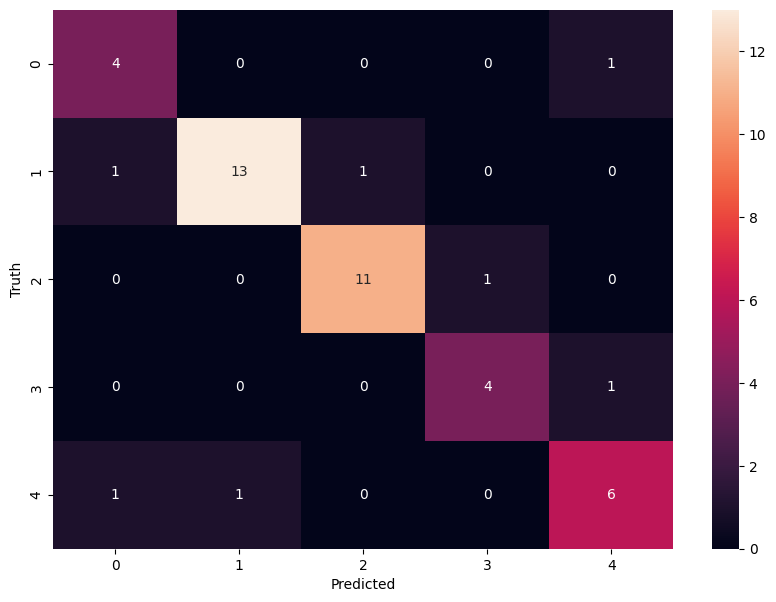

In [44]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [45]:
class_dict

{'BenedictCumberbatch': 0,
 'CilianMurphy': 1,
 'DakotaJhonson': 2,
 'EmmaStone': 3,
 'RyanGosling': 4}

# Save the Model

In [46]:
import joblib
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

save class dictionary

In [47]:
import json
with open('class_dictionary.json', 'w') as f:
          f.write(json.dumps(class_dict))